In [19]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

(1499, 1999, 3)


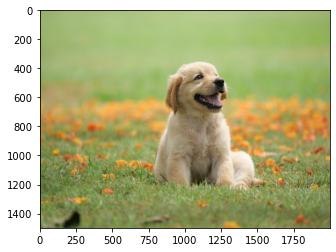

In [25]:
img = cv2.imread('dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

In [28]:
bbox0 = np.array([[160, 147, 260, 234], [137, 90, 100, 300]])
labels = np.array([1,1])

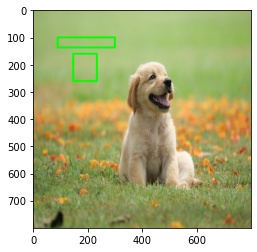

In [37]:
img_c = np.copy(img)
for i in range(len(bbox0)):
    cv2.rectangle(img_c, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=5)
plt.imshow(img_c)
plt.show()


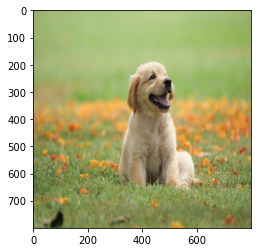

In [36]:
img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [38]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1070


In [39]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [40]:
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

torch.Size([1, 3, 800, 800])
30
512


In [55]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [57]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


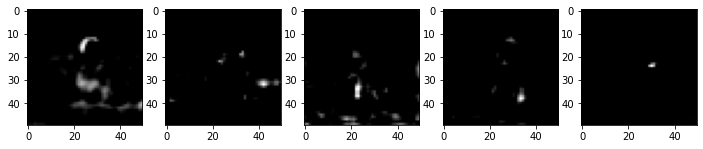

In [58]:
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()

In [59]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [60]:
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


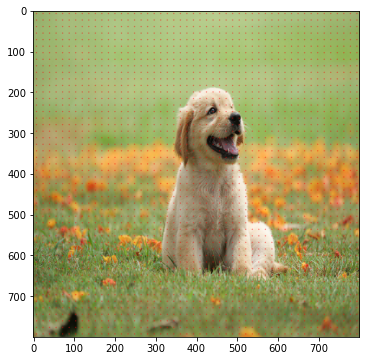

In [61]:
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_clone)
plt.show()    


In [62]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


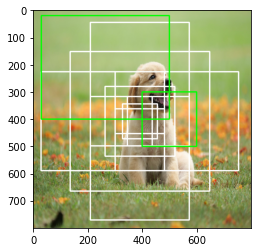

In [63]:
img_clone = np.copy(img)
for i in range(11025, 11034):  #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  